In [1]:
import numpy as np

# gravitational constant
G = 1

print("Enter values as comma-separated floats, e.g., 1.0, 2.0")

# masses
m1 = float(input("Mass of body 1 (m1): "))
m2 = float(input("Mass of body 2 (m2): "))

# Initial positions (2D vectors)
x1_0 = np.array([float(i) for i in input("Initial position of body 1 (x1, y1): ").split(",")])
x2_0 = np.array([float(i) for i in input("Initial position of body 2 (x2, y2): ").split(",")])

# Initial velocities (2D vectors)
v1_0 = np.array([float(i) for i in input("Initial velocity of body 1 (vx1, vy1): ").split(",")])
v2_0 = np.array([float(i) for i in input("Initial velocity of body 2 (vx2, vy2): ").split(",")])

# Time of prediction
T = float(input("Prediction time T (seconds): "))

print(f"m1 = {m1}, m2 = {m2}")
print(f"x1_0 = {x1_0}, x2_0 = {x2_0}")
print(f"v1_0 = {v1_0}, v2_0 = {v2_0}")
print(f"T = {T}")

Enter values as comma-separated floats, e.g., 1.0, 2.0
Mass of body 1 (m1): 10
Mass of body 2 (m2): 12
Initial position of body 1 (x1, y1): 0,0
Initial position of body 2 (x2, y2): 4,0
Initial velocity of body 1 (vx1, vy1): 2,2
Initial velocity of body 2 (vx2, vy2): 4,5
Prediction time T (seconds): 10
m1 = 10.0, m2 = 12.0
x1_0 = [0. 0.], x2_0 = [4. 0.]
v1_0 = [2. 2.], v2_0 = [4. 5.]
T = 10.0


In [2]:
from scipy.integrate import solve_ivp

def two_body_equations(t, y):
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = y
    r1 = np.array([x1, y1])
    r2 = np.array([x2, y2])
    r12 = r2 - r1
    r = np.linalg.norm(r12)

    a1 = G * m2 * r12 / r**3
    a2 = -G * m1 * r12 / r**3

    return [vx1, vy1, vx2, vy2, *a1, *a2]

# initial state
y0 = [*x1_0, *x2_0, *v1_0, *v2_0]
time_span = (0, T)
t_eval = np.linspace(0, T, 500)

sol = solve_ivp(two_body_equations, time_span, y0, t_eval=t_eval)
X_train = t_eval.reshape(-1, 1)
Y_train = sol.y.T  # positions and velocities at each time step


In [3]:
import torch
import torch.nn as nn

class TrajectoryNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 8)
        )

    def forward(self, t):
        return self.net(t)

model = TrajectoryNet()

In [4]:
def mae_loss(pred, target):
    return torch.mean(torch.abs(pred - target))

def ode_residual_loss(model, t):
    t.requires_grad_(True)

    pred = model(t)

    x1 = pred[:, 0]
    y1 = pred[:, 1]
    x2 = pred[:, 2]
    y2 = pred[:, 3]

    r1 = torch.stack([x1, y1], dim=1)
    r2 = torch.stack([x2, y2], dim=1)
    r12 = r2 - r1
    r = torch.norm(r12, dim=1, keepdim=True)

    vel = torch.autograd.grad(r1, t, grad_outputs=torch.ones_like(r1), create_graph=True)[0]
    vel2 = torch.autograd.grad(r2, t, grad_outputs=torch.ones_like(r2), create_graph=True)[0]

    acc1 = torch.autograd.grad(vel, t, grad_outputs=torch.ones_like(vel), create_graph=True)[0]
    acc2 = torch.autograd.grad(vel2, t, grad_outputs=torch.ones_like(vel2), create_graph=True)[0]

    true_acc1 = G * m2 * r12 / r**3
    true_acc2 = -G * m1 * r12 / r**3

    return torch.mean((acc1 - true_acc1)**2 + (acc2 - true_acc2)**2)



In [5]:
import torch.optim as optim

t_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(Y_train, dtype=torch.float32)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10000):
    model.train()
    optimizer.zero_grad()

    t_train_grad = t_train.clone().detach().requires_grad_(True)

    pred = model(t_train_grad)
    loss_mae = mae_loss(pred, y_train)
    loss_ode = ode_residual_loss(model, t_train_grad)
    total_loss = loss_mae + 0.1 * loss_ode

    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: MAE={loss_mae.item():.4f}, ODE={loss_ode.item():.4f}")



Epoch 0: MAE=10.4389, ODE=256793.8906
Epoch 100: MAE=8.8641, ODE=1.0744
Epoch 200: MAE=8.7888, ODE=1.0731
Epoch 300: MAE=8.7714, ODE=1.0718
Epoch 400: MAE=8.7633, ODE=1.0704
Epoch 500: MAE=8.7575, ODE=1.0687
Epoch 600: MAE=8.7522, ODE=1.0668
Epoch 700: MAE=8.7480, ODE=1.0648
Epoch 800: MAE=8.7439, ODE=1.0626
Epoch 900: MAE=8.7400, ODE=1.0601
Epoch 1000: MAE=8.7381, ODE=1.0575
Epoch 1100: MAE=8.7341, ODE=1.0547
Epoch 1200: MAE=8.7312, ODE=1.0517
Epoch 1300: MAE=8.7298, ODE=1.0486
Epoch 1400: MAE=8.7277, ODE=1.0452
Epoch 1500: MAE=8.7267, ODE=1.0418
Epoch 1600: MAE=8.7235, ODE=1.0381
Epoch 1700: MAE=8.7198, ODE=1.0343
Epoch 1800: MAE=8.7163, ODE=1.0303
Epoch 1900: MAE=8.7139, ODE=1.0261
Epoch 2000: MAE=8.7112, ODE=1.0218
Epoch 2100: MAE=8.7084, ODE=1.0173
Epoch 2200: MAE=8.7046, ODE=1.0127
Epoch 2300: MAE=8.7012, ODE=1.0079
Epoch 2400: MAE=8.6985, ODE=1.0029
Epoch 2500: MAE=8.6960, ODE=0.9978
Epoch 2600: MAE=8.6918, ODE=0.9925
Epoch 2700: MAE=8.6887, ODE=0.9870
Epoch 2800: MAE=8.6845, OD

In [7]:
model.eval()
t_test = torch.tensor([[T]], dtype=torch.float32)
final_pos = model(t_test)[0, :4].detach().numpy()
print(f"Predicted final positions at T={T}:")
print(f"x1 = {final_pos[:2]}, x2 = {final_pos[2:]}")

Predicted final positions at T=10.0:
x1 = [3.0336163 1.1396233], x2 = [7.073873  3.7909002]


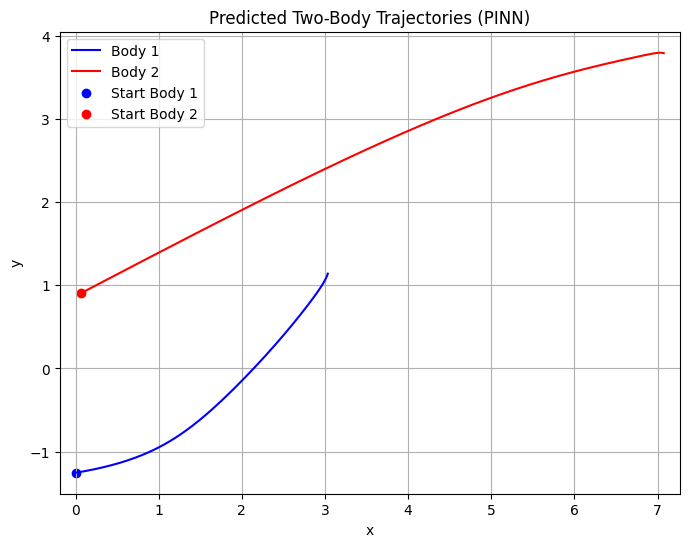

In [8]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    t_all = torch.tensor(X_train, dtype=torch.float32)
    predictions = model(t_all).numpy()

x1_pred, y1_pred = predictions[:, 0], predictions[:, 1]
x2_pred, y2_pred = predictions[:, 2], predictions[:, 3]

# predicted trajectory
plt.figure(figsize=(8, 6))
plt.plot(x1_pred, y1_pred, label="Body 1", color='blue')
plt.plot(x2_pred, y2_pred, label="Body 2", color='red')
plt.scatter(x1_pred[0], y1_pred[0], color='blue', marker='o', label='Start Body 1')
plt.scatter(x2_pred[0], y2_pred[0], color='red', marker='o', label='Start Body 2')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted Two-Body Trajectories (PINN)")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()
